In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import os
import pandas as pd
import pickle
import yaml
from pathlib import Path

import bacco
import baccoemu

import sys
sys.path.append('/dipc/kstoreyf/muchisimocks/scripts')
import data_loader
import plotter
import plot_utils
import utils
import generate_params as genp

%load_ext autoreload
%autoreload 2

2025-07-02 07:38:45.040256: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-02 07:38:45.149309: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-02 07:38:45.149352: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-02 07:38:45.163812: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-02 07:38:45.196907: I tensorflow/core/platform/cpu_feature_guar

## marcos's code

In [2]:
cosmo = utils.get_cosmo(utils.cosmo_dict_quijote)

In [3]:
# Constants and parameters
BoxSize = 1000
ngrid = 128
nmocks = 100
#nmocks = 10

# other potential differences (besides logbinning): cosmo
args_power = {
    'ngrid': ngrid,
    'box': BoxSize,
    #'cosmology': sim.Cosmology,
    'cosmology': cosmo,
    'interlacing': False,
    'kmin': 0.01,
    'kmax': 0.4,
    'nbins': 100,
    'correct_grid': False,
    'log_binning': False,
    'deposit_method': 'cic',
    'compute_correlation': False,
    'zspace': False,
    'compute_power2d': False,
    'nthreads': 8,
}


In [4]:
dir_save = '../data/marcos_sigmapk_checks'

if os.path.exists(f'{dir_save}/pks_n100.npy'):
    print("Loading precomputed power spectra")
    all_pks = np.load(f'{dir_save}/pks_n100.npy')
    all_gauss_err = np.load(f'{dir_save}/gauss_errs_n100.npy')
    k_values = np.load(f'{dir_save}/k_n100.npy')
    
else:
    print("Computing power spectra...")
    # Arrays to store power spectra
    all_pks = []
    all_gauss_err = []

    # Loop over mocks
    #for i in tqdm(range(nmocks)):
    for i in range(nmocks):
        #path = f'/cosmos_storage/simulations/BaccoSims/muchisimocks/muchisimocks_lib_quijote_p0_n1000/mock{i}/bias_fields_eul_deconvolved_{i}.npy'
        path = f'/scratch/kstoreyf/muchisimocks/muchisimocks_lib_quijote_p0_n1000/mock{i}/bias_fields_eul_deconvolved_{i}.npy'
        if not os.path.exists(path):
            print(f"File not found: {path}")
            continue

        fields = np.load(path)
        
        power = bacco.statistics.compute_crossspectrum_twogrids(
            grid1=fields[0],
            grid2=fields[0],
            normalise_grid1=True,
            normalise_grid2=True,
            deconvolve_grid1=False,
            deconvolve_grid2=False,
            **args_power
        )

        all_pks.append(power['pk'])
        all_gauss_err.append(power['pk_gaussian_error'])

    # Convert to array and compute mean/std
    all_pks = np.array(all_pks)
    all_gauss_err = np.array(all_gauss_err)
    k_values = power['k']  
    
    if not os.path.exists(dir_save):
        os.makedirs(dir_save)
    np.save(f'{dir_save}/pks_n100.npy', all_pks)
    np.save(f'{dir_save}/gauss_errs_n100.npy', all_gauss_err)
    np.save(f'{dir_save}/k_n100.npy', k_values)
    
mean_pk = np.mean(all_pks, axis=0)
std_pk = np.std(all_pks, axis=0)
mean_pk_err = np.mean(all_gauss_err, axis=0)

Loading precomputed power spectra


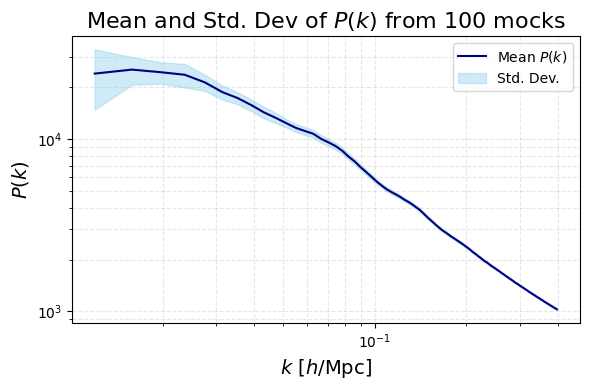

In [5]:
# Plotting
plt.figure(figsize=(6, 4))
plt.loglog(k_values, mean_pk, label='Mean $P(k)$', color='navy')
plt.fill_between(k_values, mean_pk - std_pk, mean_pk + std_pk,
                 color='skyblue', alpha=0.4, label='Std. Dev.')
plt.xlabel(r'$k\ [h/\mathrm{Mpc}]$', fontsize=14)
plt.ylabel(r'$P(k)$', fontsize=14)
plt.title('Mean and Std. Dev of $P(k)$ from 100 mocks', fontsize=16)
plt.legend()
plt.grid(True, which='both', ls='--', alpha=0.3)
plt.tight_layout()
plt.show()

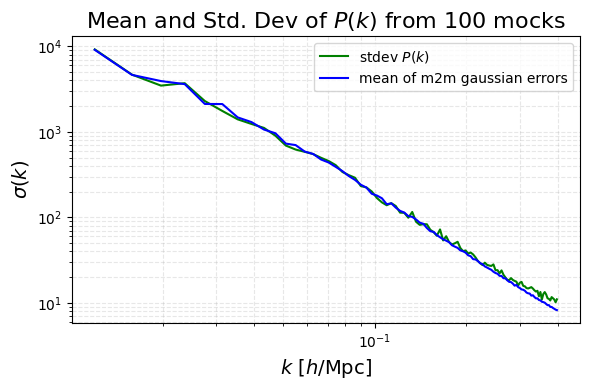

In [6]:
# Plotting
plt.figure(figsize=(6, 4))
plt.loglog(k_values, std_pk, label='stdev $P(k)$', color='green')
plt.loglog(k_values, mean_pk_err, label='mean of m2m gaussian errors', color='blue')

plt.xlabel(r'$k\ [h/\mathrm{Mpc}]$', fontsize=14)
plt.ylabel(r'$\sigma(k)$', fontsize=14)
plt.title('Mean and Std. Dev of $P(k)$ from 100 mocks', fontsize=16)
plt.legend()
plt.grid(True, which='both', ls='--', alpha=0.3)
plt.tight_layout()
plt.show()

### aha, he's not using log_binning! now with log_binning=True:

In [7]:
args_power_logbinning = np.copy(args_power).item()
args_power_logbinning['log_binning'] = True
args_power_logbinning['nbins'] = 30 # match mine

In [8]:
dir_save = '../data/marcos_sigmapk_checks'
overwrite = True

if os.path.exists(f'{dir_save}/pks_lb_n100.npy') and not overwrite:
    print("Loading precomputed power spectra")
    all_pks_lb = np.load(f'{dir_save}/pks_lb_n100.npy')
    all_gauss_err_lb = np.load(f'{dir_save}/gauss_errs_lb_n100.npy')
    k_values_lb = np.load(f'{dir_save}/k_lb_n100.npy')

else:
    print("Computing power spectra...")
    # Arrays to store power spectra
    all_pks_lb = []
    all_gauss_err_lb = []

    # Loop over mocks
    #for i in tqdm(range(nmocks)):
    for i in range(nmocks):
        #path = f'/cosmos_storage/simulations/BaccoSims/muchisimocks/muchisimocks_lib_quijote_p0_n1000/mock{i}/bias_fields_eul_deconvolved_{i}.npy'
        path = f'/scratch/kstoreyf/muchisimocks/muchisimocks_lib_quijote_p0_n1000/mock{i}/bias_fields_eul_deconvolved_{i}.npy'
        if not os.path.exists(path):
            print(f"File not found: {path}")
            continue

        fields = np.load(path)
        
        power = bacco.statistics.compute_crossspectrum_twogrids(
            grid1=fields[0],
            grid2=fields[0],
            normalise_grid1=True,
            normalise_grid2=True,
            deconvolve_grid1=False,
            deconvolve_grid2=False,
            **args_power_logbinning
        )

        all_pks_lb.append(power['pk'])
        all_gauss_err_lb.append(power['pk_gaussian_error'])

    # Convert to array and compute mean/std
    all_pks_lb = np.array(all_pks_lb)
    all_gauss_err_lb = np.array(all_gauss_err_lb)
    k_values_lb = power['k']

    if not os.path.exists(dir_save):
        os.makedirs(dir_save)
    np.save(f'{dir_save}/pks_lb_n100.npy', all_pks_lb)
    np.save(f'{dir_save}/gauss_errs_lb_n100.npy', all_gauss_err_lb)
    np.save(f'{dir_save}/k_lb_n100.npy', k_values_lb)

mean_pk_lb = np.mean(all_pks_lb, axis=0)
std_pk_lb = np.std(all_pks_lb, axis=0)
mean_pk_err_lb = np.mean(all_gauss_err_lb, axis=0)

2025-07-02 07:38:52,825 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


Computing power spectra...


2025-07-02 07:38:54,336 bacco.statistics :  ...done in 1.51 s
2025-07-02 07:38:54,349 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.34218e+08 (grid1) 1.34218e+08 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.095585 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.107458 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000202 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 128; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.34218e+08 (grid1) 1.34218e+08 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.002395 sec
bacco.power : Counting modes


2025-07-02 07:38:54,435 bacco.statistics :  ...done in 0.0861 s
2025-07-02 07:38:54,447 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2025-07-02 07:38:54,533 bacco.statistics :  ...done in 0.0867 s
2025-07-02 07:38:54,546 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2025-07-02 07:38:54,627 bacco.statistics :  ...done in 0.0809 s


bacco.power : done counting modes in 0.073417 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000201 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 128; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.34218e+08 (grid1) 1.34218e+08 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.002381 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.075249 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000200 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 128; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_

2025-07-02 07:38:54,640 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2025-07-02 07:38:54,722 bacco.statistics :  ...done in 0.0822 s
2025-07-02 07:38:54,734 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2025-07-02 07:38:54,768 bacco.statistics :  ...done in 0.0336 s
2025-07-02 07:38:54,829 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.34218e+08 (grid1) 1.34218e+08 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.002354 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.021618 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000196 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 128; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.34218e+08 (grid1) 1.34218e+08 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.002381 sec
bacco.power : Counting modes
bacco.po

2025-07-02 07:38:54,863 bacco.statistics :  ...done in 0.0337 s
2025-07-02 07:38:54,929 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2025-07-02 07:38:54,962 bacco.statistics :  ...done in 0.0333 s
2025-07-02 07:38:55,028 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : done counting modes in 0.021899 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000198 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 128; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.34218e+08 (grid1) 1.34218e+08 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.002442 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.022518 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000202 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 128; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_

2025-07-02 07:38:55,063 bacco.statistics :  ...done in 0.0348 s
2025-07-02 07:38:55,127 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2025-07-02 07:38:55,162 bacco.statistics :  ...done in 0.0342 s
2025-07-02 07:38:55,228 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2025-07-02 07:38:55,261 bacco.statistics :  ...done in 0.0333 s
2025-07-02 07:38:55,324 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.34218e+08 (grid1) 1.34218e+08 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.002422 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.022088 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000204 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 128; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.34218e+08 (grid1) 1.34218e+08 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.002373 sec
bacco.power : Counting modes
bacco.po

2025-07-02 07:38:55,357 bacco.statistics :  ...done in 0.0334 s
2025-07-02 07:38:55,422 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2025-07-02 07:38:55,455 bacco.statistics :  ...done in 0.0328 s
2025-07-02 07:38:55,467 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2025-07-02 07:38:55,552 bacco.statistics :  ...done in 0.0854 s


bacco.power : done counting modes in 0.022148 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000202 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 128; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.34218e+08 (grid1) 1.34218e+08 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.002346 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.021802 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000202 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 128; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_

2025-07-02 07:38:55,565 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2025-07-02 07:38:55,650 bacco.statistics :  ...done in 0.0844 s
2025-07-02 07:38:55,662 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2025-07-02 07:38:55,748 bacco.statistics :  ...done in 0.0865 s
2025-07-02 07:38:55,761 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.34218e+08 (grid1) 1.34218e+08 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.003047 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.022908 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000200 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 128; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.34218e+08 (grid1) 1.34218e+08 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.055013 sec
bacco.power : Counting modes
bacco.po

2025-07-02 07:38:55,847 bacco.statistics :  ...done in 0.086 s
2025-07-02 07:38:55,860 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2025-07-02 07:38:55,946 bacco.statistics :  ...done in 0.0863 s
2025-07-02 07:38:55,958 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2025-07-02 07:38:56,041 bacco.statistics :  ...done in 0.0824 s


bacco.power : done counting modes in 0.021818 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000130 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 128; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.34218e+08 (grid1) 1.34218e+08 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.055726 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.021105 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000220 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 128; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_

2025-07-02 07:38:56,054 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2025-07-02 07:38:56,137 bacco.statistics :  ...done in 0.0834 s
2025-07-02 07:38:56,149 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2025-07-02 07:38:56,237 bacco.statistics :  ...done in 0.0875 s
2025-07-02 07:38:56,251 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.34218e+08 (grid1) 1.34218e+08 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.002317 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.073221 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000223 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 128; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.34218e+08 (grid1) 1.34218e+08 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.002356 sec
bacco.power : Counting modes
bacco.po

2025-07-02 07:38:56,335 bacco.statistics :  ...done in 0.0837 s
2025-07-02 07:38:56,347 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2025-07-02 07:38:56,429 bacco.statistics :  ...done in 0.0814 s
2025-07-02 07:38:56,441 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2025-07-02 07:38:56,526 bacco.statistics :  ...done in 0.0848 s


bacco.power : done counting modes in 0.071815 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000221 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 128; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.34218e+08 (grid1) 1.34218e+08 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.002318 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.071563 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000217 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 128; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_

2025-07-02 07:38:56,538 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2025-07-02 07:38:56,569 bacco.statistics :  ...done in 0.0315 s
2025-07-02 07:38:56,635 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2025-07-02 07:38:56,668 bacco.statistics :  ...done in 0.0336 s
2025-07-02 07:38:56,731 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.34218e+08 (grid1) 1.34218e+08 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.002312 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.020918 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000225 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 128; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.34218e+08 (grid1) 1.34218e+08 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.002322 sec
bacco.power : Counting modes
bacco.po

2025-07-02 07:38:56,767 bacco.statistics :  ...done in 0.0356 s
2025-07-02 07:38:56,831 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2025-07-02 07:38:56,863 bacco.statistics :  ...done in 0.0315 s
2025-07-02 07:38:56,928 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2025-07-02 07:38:56,960 bacco.statistics :  ...done in 0.0317 s


bacco.power : done counting modes in 0.023637 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000239 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 128; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.34218e+08 (grid1) 1.34218e+08 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.002331 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.020840 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000220 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 128; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_

2025-07-02 07:38:56,972 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2025-07-02 07:38:57,057 bacco.statistics :  ...done in 0.0856 s
2025-07-02 07:38:57,123 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2025-07-02 07:38:57,155 bacco.statistics :  ...done in 0.0321 s
2025-07-02 07:38:57,167 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.34218e+08 (grid1) 1.34218e+08 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.002313 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.024107 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000228 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 128; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.34218e+08 (grid1) 1.34218e+08 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.002365 sec
bacco.power : Counting modes
bacco.po

2025-07-02 07:38:57,264 bacco.statistics :  ...done in 0.0966 s
2025-07-02 07:38:57,329 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2025-07-02 07:38:57,362 bacco.statistics :  ...done in 0.0333 s
2025-07-02 07:38:57,427 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2025-07-02 07:38:57,462 bacco.statistics :  ...done in 0.0342 s


bacco.power : done counting modes in 0.033707 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000132 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 128; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.34218e+08 (grid1) 1.34218e+08 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.002367 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.023049 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000230 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 128; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_

2025-07-02 07:38:57,527 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2025-07-02 07:38:57,560 bacco.statistics :  ...done in 0.0333 s
2025-07-02 07:38:57,626 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2025-07-02 07:38:57,661 bacco.statistics :  ...done in 0.0348 s
2025-07-02 07:38:57,726 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.34218e+08 (grid1) 1.34218e+08 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.002338 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.023092 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000221 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 128; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.34218e+08 (grid1) 1.34218e+08 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.002328 sec
bacco.power : Counting modes
bacco.po

2025-07-02 07:38:57,761 bacco.statistics :  ...done in 0.0353 s
2025-07-02 07:38:57,827 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2025-07-02 07:38:57,860 bacco.statistics :  ...done in 0.0334 s
2025-07-02 07:38:57,928 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : done counting modes in 0.023559 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000222 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 128; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.34218e+08 (grid1) 1.34218e+08 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.002331 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.023033 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000227 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 128; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_

2025-07-02 07:38:57,965 bacco.statistics :  ...done in 0.0366 s
2025-07-02 07:38:58,031 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2025-07-02 07:38:58,065 bacco.statistics :  ...done in 0.034 s
2025-07-02 07:38:58,130 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2025-07-02 07:38:58,164 bacco.statistics :  ...done in 0.0335 s


bacco.power : done counting modes in 0.024459 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000224 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 128; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.34218e+08 (grid1) 1.34218e+08 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.002334 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.023291 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000221 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 128; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_

2025-07-02 07:38:58,230 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2025-07-02 07:38:58,264 bacco.statistics :  ...done in 0.0343 s
2025-07-02 07:38:58,330 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2025-07-02 07:38:58,364 bacco.statistics :  ...done in 0.0337 s
2025-07-02 07:38:58,429 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.34218e+08 (grid1) 1.34218e+08 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.002382 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.023490 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000237 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 128; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.34218e+08 (grid1) 1.34218e+08 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.002335 sec
bacco.power : Counting modes
bacco.po

2025-07-02 07:38:58,464 bacco.statistics :  ...done in 0.0348 s
2025-07-02 07:38:58,530 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2025-07-02 07:38:58,566 bacco.statistics :  ...done in 0.0361 s
2025-07-02 07:38:58,631 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : done counting modes in 0.023879 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000134 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 128; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.34218e+08 (grid1) 1.34218e+08 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.002301 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.023858 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000222 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 128; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_

2025-07-02 07:38:58,665 bacco.statistics :  ...done in 0.0345 s
2025-07-02 07:38:58,731 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2025-07-02 07:38:58,765 bacco.statistics :  ...done in 0.034 s
2025-07-02 07:38:58,831 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : done counting modes in 0.023286 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000127 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 128; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.34218e+08 (grid1) 1.34218e+08 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.002408 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.023602 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000229 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 128; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_

2025-07-02 07:38:58,868 bacco.statistics :  ...done in 0.0368 s
2025-07-02 07:38:58,932 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2025-07-02 07:38:58,966 bacco.statistics :  ...done in 0.0339 s
2025-07-02 07:38:59,035 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : done counting modes in 0.024490 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000226 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 128; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.34218e+08 (grid1) 1.34218e+08 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.002343 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.023099 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000224 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 128; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_

2025-07-02 07:38:59,071 bacco.statistics :  ...done in 0.0353 s
2025-07-02 07:38:59,136 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2025-07-02 07:38:59,225 bacco.statistics :  ...done in 0.0895 s
2025-07-02 07:38:59,239 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : done counting modes in 0.024083 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000131 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 128; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.34218e+08 (grid1) 1.34218e+08 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.002374 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.078102 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000135 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 128; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_

2025-07-02 07:38:59,323 bacco.statistics :  ...done in 0.0836 s
2025-07-02 07:38:59,337 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2025-07-02 07:38:59,372 bacco.statistics :  ...done in 0.0347 s
2025-07-02 07:38:59,433 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2025-07-02 07:38:59,470 bacco.statistics :  ...done in 0.0365 s


bacco.power : done counting modes in 0.022635 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000191 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 128; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.34218e+08 (grid1) 1.34218e+08 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.002391 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.023622 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000133 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 128; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_

2025-07-02 07:38:59,534 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2025-07-02 07:38:59,569 bacco.statistics :  ...done in 0.0351 s
2025-07-02 07:38:59,632 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2025-07-02 07:38:59,666 bacco.statistics :  ...done in 0.0334 s
2025-07-02 07:38:59,733 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.34218e+08 (grid1) 1.34218e+08 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.002303 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.023865 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000148 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 128; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.34218e+08 (grid1) 1.34218e+08 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.002334 sec
bacco.power : Counting modes
bacco.po

2025-07-02 07:38:59,823 bacco.statistics :  ...done in 0.0904 s
2025-07-02 07:38:59,838 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2025-07-02 07:38:59,925 bacco.statistics :  ...done in 0.0876 s
2025-07-02 07:38:59,940 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : done counting modes in 0.024625 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000194 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 128; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.34218e+08 (grid1) 1.34218e+08 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.002333 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.076022 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000134 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 128; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_

2025-07-02 07:39:00,028 bacco.statistics :  ...done in 0.0885 s
2025-07-02 07:39:00,041 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2025-07-02 07:39:00,129 bacco.statistics :  ...done in 0.0875 s
2025-07-02 07:39:00,142 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2025-07-02 07:39:00,227 bacco.statistics :  ...done in 0.0847 s


bacco.power : done counting modes in 0.077825 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000127 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 128; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.34218e+08 (grid1) 1.34218e+08 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.002358 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.076963 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000127 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 128; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_

2025-07-02 07:39:00,240 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2025-07-02 07:39:00,326 bacco.statistics :  ...done in 0.0861 s
2025-07-02 07:39:00,339 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2025-07-02 07:39:00,424 bacco.statistics :  ...done in 0.0857 s
2025-07-02 07:39:00,437 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.34218e+08 (grid1) 1.34218e+08 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.002366 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.075282 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000191 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 128; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.34218e+08 (grid1) 1.34218e+08 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.002305 sec
bacco.power : Counting modes
bacco.po

2025-07-02 07:39:00,521 bacco.statistics :  ...done in 0.0847 s
2025-07-02 07:39:00,535 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2025-07-02 07:39:00,569 bacco.statistics :  ...done in 0.0343 s
2025-07-02 07:39:00,632 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2025-07-02 07:39:00,668 bacco.statistics :  ...done in 0.0363 s


bacco.power : done counting modes in 0.023466 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000125 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 128; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.34218e+08 (grid1) 1.34218e+08 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.002316 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.023911 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000127 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 128; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_

2025-07-02 07:39:00,731 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2025-07-02 07:39:00,766 bacco.statistics :  ...done in 0.0349 s
2025-07-02 07:39:00,831 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2025-07-02 07:39:00,864 bacco.statistics :  ...done in 0.0331 s
2025-07-02 07:39:00,929 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.34218e+08 (grid1) 1.34218e+08 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.002359 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.023840 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000143 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 128; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.34218e+08 (grid1) 1.34218e+08 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.002351 sec
bacco.power : Counting modes
bacco.po

2025-07-02 07:39:00,964 bacco.statistics :  ...done in 0.035 s
2025-07-02 07:39:01,029 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2025-07-02 07:39:01,063 bacco.statistics :  ...done in 0.0336 s
2025-07-02 07:39:01,130 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2025-07-02 07:39:01,163 bacco.statistics :  ...done in 0.0338 s


bacco.power : done counting modes in 0.023993 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000194 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 128; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.34218e+08 (grid1) 1.34218e+08 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.002298 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.022388 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000190 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 128; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_

2025-07-02 07:39:01,231 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2025-07-02 07:39:01,266 bacco.statistics :  ...done in 0.0355 s
2025-07-02 07:39:01,332 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2025-07-02 07:39:01,367 bacco.statistics :  ...done in 0.0348 s
2025-07-02 07:39:01,432 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.34218e+08 (grid1) 1.34218e+08 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.002308 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.023154 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000130 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 128; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.34218e+08 (grid1) 1.34218e+08 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.002307 sec
bacco.power : Counting modes
bacco.po

2025-07-02 07:39:01,465 bacco.statistics :  ...done in 0.0332 s
2025-07-02 07:39:01,530 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2025-07-02 07:39:01,567 bacco.statistics :  ...done in 0.0363 s
2025-07-02 07:39:01,631 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : done counting modes in 0.022328 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000125 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 128; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.34218e+08 (grid1) 1.34218e+08 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.002263 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.024042 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000190 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 128; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_

2025-07-02 07:39:01,666 bacco.statistics :  ...done in 0.0343 s
2025-07-02 07:39:01,732 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2025-07-02 07:39:01,767 bacco.statistics :  ...done in 0.0342 s
2025-07-02 07:39:01,832 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2025-07-02 07:39:01,865 bacco.statistics :  ...done in 0.0335 s
2025-07-02 07:39:01,932 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.34218e+08 (grid1) 1.34218e+08 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.002341 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.023901 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000189 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 128; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.34218e+08 (grid1) 1.34218e+08 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.002351 sec
bacco.power : Counting modes
bacco.po

2025-07-02 07:39:01,966 bacco.statistics :  ...done in 0.0347 s
2025-07-02 07:39:02,032 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2025-07-02 07:39:02,064 bacco.statistics :  ...done in 0.0329 s
2025-07-02 07:39:02,130 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : done counting modes in 0.023306 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000142 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 128; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.34218e+08 (grid1) 1.34218e+08 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.002390 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.022043 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000191 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 128; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_

2025-07-02 07:39:02,166 bacco.statistics :  ...done in 0.036 s
2025-07-02 07:39:02,231 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2025-07-02 07:39:02,265 bacco.statistics :  ...done in 0.0337 s
2025-07-02 07:39:02,333 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2025-07-02 07:39:02,427 bacco.statistics :  ...done in 0.0945 s
2025-07-02 07:39:02,441 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.34218e+08 (grid1) 1.34218e+08 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.002312 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.022316 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000181 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 128; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.34218e+08 (grid1) 1.34218e+08 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.003048 sec
bacco.power : Counting modes
bacco.po

2025-07-02 07:39:02,525 bacco.statistics :  ...done in 0.0843 s
2025-07-02 07:39:02,538 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2025-07-02 07:39:02,624 bacco.statistics :  ...done in 0.0858 s
2025-07-02 07:39:02,637 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : done counting modes in 0.072563 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000124 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 128; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.34218e+08 (grid1) 1.34218e+08 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.002275 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.075025 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000505 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 128; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_

2025-07-02 07:39:02,724 bacco.statistics :  ...done in 0.087 s
2025-07-02 07:39:02,738 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2025-07-02 07:39:02,824 bacco.statistics :  ...done in 0.0866 s
2025-07-02 07:39:02,837 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2025-07-02 07:39:02,872 bacco.statistics :  ...done in 0.0342 s
2025-07-02 07:39:02,933 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.34218e+08 (grid1) 1.34218e+08 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.002294 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.075976 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000499 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 128; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.34218e+08 (grid1) 1.34218e+08 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.002264 sec
bacco.power : Counting modes
bacco.po

2025-07-02 07:39:02,967 bacco.statistics :  ...done in 0.0339 s
2025-07-02 07:39:03,032 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2025-07-02 07:39:03,065 bacco.statistics :  ...done in 0.0339 s
2025-07-02 07:39:03,132 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : done counting modes in 0.023949 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000218 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 128; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.34218e+08 (grid1) 1.34218e+08 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.002257 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.022563 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000139 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 128; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_

2025-07-02 07:39:03,166 bacco.statistics :  ...done in 0.0331 s
2025-07-02 07:39:03,229 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2025-07-02 07:39:03,264 bacco.statistics :  ...done in 0.0342 s
2025-07-02 07:39:03,329 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2025-07-02 07:39:03,365 bacco.statistics :  ...done in 0.0364 s
2025-07-02 07:39:03,429 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.34218e+08 (grid1) 1.34218e+08 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.002347 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.024340 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000149 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 128; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.34218e+08 (grid1) 1.34218e+08 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.002255 sec
bacco.power : Counting modes
bacco.po

2025-07-02 07:39:03,463 bacco.statistics :  ...done in 0.0337 s
2025-07-02 07:39:03,529 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2025-07-02 07:39:03,561 bacco.statistics :  ...done in 0.0323 s
2025-07-02 07:39:03,628 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : total mass 1.34218e+08 (grid1) 1.34218e+08 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.002271 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.023553 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000133 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 128; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.34218e+08 (grid1) 1.34218e+08 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.002342 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.023004 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000128 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 128; nthreads 8; interlacing 0; deposit_method 1; log_

2025-07-02 07:39:03,662 bacco.statistics :  ...done in 0.0347 s
2025-07-02 07:39:03,728 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2025-07-02 07:39:03,762 bacco.statistics :  ...done in 0.0342 s
2025-07-02 07:39:03,827 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2025-07-02 07:39:03,859 bacco.statistics :  ...done in 0.0326 s
2025-07-02 07:39:03,926 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.34218e+08 (grid1) 1.34218e+08 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.002304 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.023953 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000127 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 128; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.34218e+08 (grid1) 1.34218e+08 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.002333 sec
bacco.power : Counting modes
bacco.po

2025-07-02 07:39:03,961 bacco.statistics :  ...done in 0.0345 s
2025-07-02 07:39:04,026 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2025-07-02 07:39:04,059 bacco.statistics :  ...done in 0.0334 s


bacco.power : done counting modes in 0.022554 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000217 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 128; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.34218e+08 (grid1) 1.34218e+08 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.002348 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.023120 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000141 secs
bacco.power : Deallocating arrays


## ksf's saved data

In [9]:
data_mode = 'muchisimocks'
statistics = ['pk']

tag_params_cv = '_quijote_p0_n1000'
tag_biasparams_cv_b0000 = '_b0000_p0_n1'
tag_datagen = ''
kwargs_data = {
    'tag_datagen': tag_datagen
}

tag_stats = f'_{"_".join(statistics)}'    
tag_data_cv_b0000 = '_'+data_mode + tag_stats + tag_params_cv + tag_biasparams_cv_b0000 + tag_datagen

In [10]:
k_cv_b0000, y_cv_b0000, y_err_cv_b0000, idxs_params_cv_b0000, params_df_cv_b0000, param_dict_fixed_cv_b0000, biasparams_df_cv_b0000, biasparams_dict_fixed_cv_b0000, random_ints_cosmo_cv_b0000, random_ints_bias_cv_b0000 = \
            data_loader.load_data(data_mode, statistics, 
                                    tag_params_cv, tag_biasparams_cv_b0000,
                                    tag_data=tag_data_cv_b0000,
                                    kwargs=kwargs_data)
k_cv_b0000, y_cv_b0000, y_err_cv_b0000 = k_cv_b0000[0], y_cv_b0000[0], y_err_cv_b0000[0]

Loading muchisimocks data
Found 1000 diff cosmo pnns in /scratch/kstoreyf/muchisimocks/data/pnns_mlib/pnns_quijote_p0_n1000
Loaded pk data with shape (1000, 30)
fn_mask: ../data/masks/mask_muchisimocks_pk_quijote_p0_n1000_b0000_p0_n1.txt
Loading from ../data/masks/mask_muchisimocks_pk_quijote_p0_n1000_b0000_p0_n1.txt (already exists)
Masked 1 out of 30 bins


In [11]:
i_nmocks = np.where(idxs_params_cv_b0000[:,0] < nmocks)[0]
y_cv_b0000 = y_cv_b0000[i_nmocks]
y_err_cv_b0000 = y_err_cv_b0000[i_nmocks]

In [12]:
cov_fid_b0000 = np.cov(y_cv_b0000, rowvar=False)


In [13]:
box_size = 1000
y_cv_b0000_std = np.std(y_cv_b0000, axis=0)
y_cv_b0000_mean = y_cv_b0000.mean(axis=0)

bacco.configuration.update({'pknbody' : {'log_binning' : True}})
g_err_b000_mean_logbinning = bacco.statistics.approx_pk_gaussian_error(k_cv_b0000, y_cv_b0000_mean, box_size)

## plot and compare

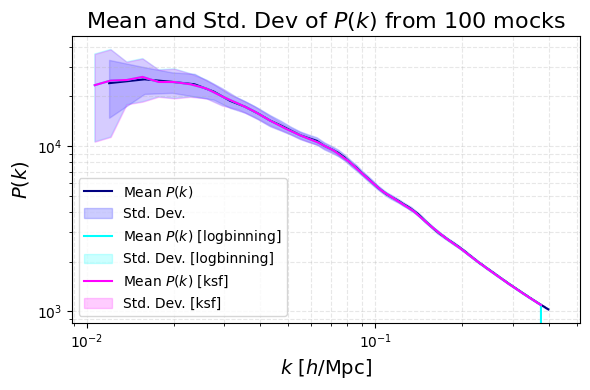

In [14]:
# Plotting
plt.figure(figsize=(6, 4))

plt.loglog(k_values, mean_pk, label='Mean $P(k)$', color='navy')
plt.fill_between(k_values, mean_pk - std_pk, mean_pk + std_pk,
                 color='blue', alpha=0.2, label='Std. Dev.')

plt.loglog(k_values_lb, mean_pk_lb, label='Mean $P(k)$ [logbinning]', color='cyan')
plt.fill_between(k_values_lb, mean_pk_lb - std_pk_lb, mean_pk_lb + std_pk_lb,
                 color='cyan', alpha=0.2, label='Std. Dev. [logbinning]')

plt.loglog(k_cv_b0000, y_cv_b0000_mean, label='Mean $P(k)$ [ksf]', color='magenta')
plt.fill_between(k_cv_b0000, y_cv_b0000_mean - y_cv_b0000_std, y_cv_b0000_mean + y_cv_b0000_std,
                 color='magenta', alpha=0.2, label='Std. Dev. [ksf]')
plt.xlabel(r'$k\ [h/\mathrm{Mpc}]$', fontsize=14)
plt.ylabel(r'$P(k)$', fontsize=14)
plt.title('Mean and Std. Dev of $P(k)$ from 100 mocks', fontsize=16)
plt.legend()
plt.grid(True, which='both', ls='--', alpha=0.3)
plt.tight_layout()
plt.show()

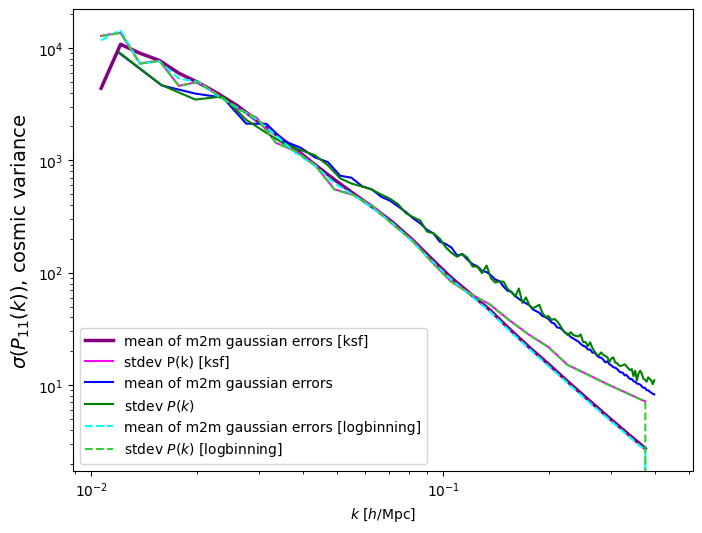

In [16]:
plt.figure(figsize=(8,6))
#plt.plot(k, np.sqrt(np.diag(cov_fid_emu)), color=color_emu, label='emu (computed from 1000 draws)', alpha=0.6)
plt.plot(k_cv_b0000, g_err_b000_mean_logbinning, color='purple', label='mean of m2m gaussian errors [ksf]', lw=2.5)
plt.plot(k_cv_b0000, np.sqrt(np.diag(cov_fid_b0000)), color='magenta', label='stdev P(k) [ksf]')

plt.loglog(k_values, mean_pk_err, label='mean of m2m gaussian errors', color='blue')
plt.loglog(k_values, std_pk, label='stdev $P(k)$', color='green')

plt.loglog(k_values_lb, mean_pk_err_lb, label='mean of m2m gaussian errors [logbinning]', color='cyan', ls='--')
plt.loglog(k_values_lb, std_pk_lb, label='stdev $P(k)$ [logbinning]', color='limegreen', ls='--')

# plt.plot(k_pnn, g_err, color=color_emu, label='emu (via approx_pk_gaussian_error)', ls=':', lw=1.5)
# plt.plot(k_pnn, g_err_logbinning, color=color_emu, label='emu (via approx_pk_gaussian_error, log binning)', ls='--', lw=1.5)


plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k\ [h/\mathrm{Mpc}]$')
plt.ylabel(r'$\sigma(P_\text{11}(k))$, cosmic variance', fontsize=14)
plt.legend(fontsize=10, loc='lower left')